# Transfer Learning with SuperGradients

In the following tutorial, we will demonstrate how to use SuperGradients to perform transfer learning for object detection. In our scenario, we will try to transfer-learn from our COCO-pretrained YoloV5nano, to a sub-dataset of Pascal VOC that includes the "person" class only.

In order to do so we will:


*   Generate new anchors that are a better fit to our new dataset.
*   Load our pretrained YoloV5nano, replace it's anchors and it's detect layers according to the new number of classes (single class)


*   Define training parameters.
*   Start training!





First, let's install the latest version of super-gradients:

In [15]:
! pip install https://deci-pretrained-models.s3.amazonaws.com/super_gradients-1.5.0rc2428-py3-none-any.whl gwpy &> /dev/null
! pip install matplotlib==3.1.3

Imports:

In [16]:
import super_gradients
from super_gradients.training import SgModel, MultiGPUMode
from super_gradients.training.datasets.dataset_interfaces.dataset_interface import \
    PascalVOCUnifiedDetectionDataSetInterface
from super_gradients.training.models.detection_models.yolov5 import YoloV5PostPredictionCallback
from super_gradients.training.utils.detection_utils import base_detection_collate_fn
from super_gradients.training.metrics import DetectionMetrics
from super_gradients.training.utils.detection_utils import Anchors
from super_gradients.training.utils.detection_utils import AnchorGenerator
import os
super_gradients.init_trainer()

# Generating new anchors

Since our model has been trained with anchors that were a good fit for the 80 classes from COCO dataset, its likely that we can find a better fit for our single class, which intutively has typical bounding boxes for it.

Let's start with downloading the data and intializing a dataset interface that we will use for the anchor generation:

In [17]:
dataset_params_anchors = {"batch_size": 1,
                          "val_batch_size": 1,
                          "train_image_size": 512,
                          "val_image_size": 512,
                          "train_sample_loading_method": "default",
                          "class_inclusion_list": ['person'],
                          "download": True,
                          "data_root": "/home/data/pascal_unified_coco_format/"
                          }
dataset_interface = PascalVOCUnifiedDetectionDataSetInterface(dataset_params=dataset_params_anchors, cache_labels=True)

  0%|          | 0.00/425M [00:00<?, ?B/s]

Unzipping /home/data/pascal_unified_coco_format/images/VOCtrainval_06-Nov-2007.zip...


  0%|          | 0.00/418M [00:00<?, ?B/s]

Unzipping /home/data/pascal_unified_coco_format/images/VOCtest_06-Nov-2007.zip...


  0%|          | 0.00/1.82G [00:00<?, ?B/s]

Unzipping /home/data/pascal_unified_coco_format/images/VOCtrainval_11-May-2012.zip...


test2007: 100%|██████████| 4952/4952 [00:05<00:00, 853.03it/s] 
Caching labels (1025 found, 1473 missing, 0 duplicate, for 2501 images): 100%|██████████| 2501/2501 [00:00<00:00, 6420.75it/s]
Caching labels (1994 found, 3723 missing, 0 duplicate, for 5717 images): 100%|██████████| 5717/5717 [00:00<00:00, 6736.66it/s]
Caching labels (983 found, 1527 missing, 0 duplicate, for 2510 images): 100%|██████████| 2510/2510 [00:00<00:00, 6681.37it/s]
Caching labels (2093 found, 3730 missing, 0 duplicate, for 5823 images): 100%|██████████| 5823/5823 [00:00<00:00, 6580.77it/s]


[Errno 2] No such file or directory: '/home/data/pascal_unified_coco_format/images/VOCdevkit/VOC2007/ImageSets/Main/test.shapes'


Reading image shapes: 100%|██████████| 4952/4952 [00:08<00:00, 596.33it/s]
Caching labels (2007 found, 2945 missing, 0 duplicate, for 4952 images): 100%|██████████| 4952/4952 [00:00<00:00, 6616.69it/s]


Moving on to generating the anchors:

Reading image shapes: 100%|██████████| 6095/6095 [00:03<00:00, 1606.18it/s]


detection_utils -INFO- Running kmeans for 9 anchors on 13256 points...
detection_utils -INFO- Initial results
detection_utils -INFO- thr=0.34: 0.9941 best possible recall, 4.93 anchors past thr
detection_utils -INFO- num_anchors=9, img_size=512
detection_utils -INFO-  metric_all=0.404/0.770-mean/best, past_thr=0.578-mean: 
29,51,  54,104,  92,159,  101,246,  183,216,  159,338,  271,295,  280,440,  428,338


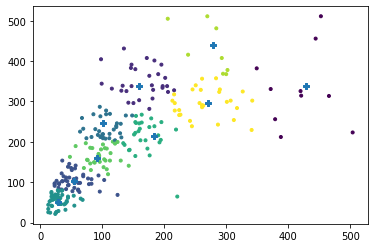

Anchors Generator: Evolving anchors with Genetic Algorithm: fitness = 0.7843: 100%|██████████| 1000/1000 [00:06<00:00, 159.36it/s]

detection_utils -INFO- Final results
detection_utils -INFO- thr=0.34: 0.9978 best possible recall, 4.98 anchors past thr
detection_utils -INFO- num_anchors=9, img_size=512


detection_utils -INFO-  metric_all=0.408/0.785-mean/best, past_thr=0.579-mean: 
23,47,  36,88,  65,118,  79,217,  123,165,  135,279,  197,251,  244,355,  388,336


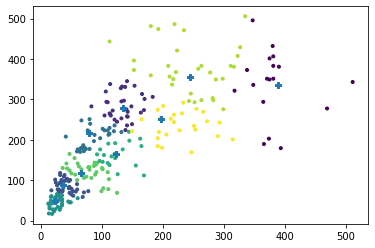

In [19]:
anch_gen = AnchorGenerator()
anchors = anch_gen(dataset=dataset_interface.trainset, thresh=1/2.91)
anchors = Anchors(anchors_list=anchors,
                  strides=[8, 16, 32])

# Defining dataset parameters for training

Now that we are done with generating new anchors, let's change our dataset parameters to incorprate augmentations, change the batch size and use mosaic sampling method:

In [20]:
dataset_params = {"batch_size": 48,
                  "val_batch_size": 48,
                  "train_image_size": 512,
                  "val_image_size": 512,
                  "val_collate_fn": base_detection_collate_fn,
                  "train_collate_fn": base_detection_collate_fn,
                  "train_sample_loading_method": "mosaic",
                  "val_sample_loading_method": "default",
                  "dataset_hyper_param": {
                      "hsv_h": 0.015,  # IMAGE HSV-Hue AUGMENTATION (fraction)
                      "hsv_s": 0.7,  # IMAGE HSV-Saturation AUGMENTATION (fraction)
                      "hsv_v": 0.4,  # IMAGE HSV-Value AUGMENTATION (fraction)
                      "degrees": 0.0,  # IMAGE ROTATION (+/- deg)
                      "translate": 0.1,  # IMAGE TRANSLATION (+/- fraction)
                      "scale": 0.5,  # IMAGE SCALE (+/- gain)
                      "shear": 0.0},  # IMAGE SHEAR (+/- deg)
                  "class_inclusion_list": ['person'],
                  "download": False,
                  "data_root": "/home/data/pascal_unified_coco_format/"
                  }


Initialize an SgModel instance, and a Pascal VOC dataset interface:

In [21]:
model = SgModel("yolov5n_pascal_finetune", ckpt_root_dir="/home/data/notebook_ckpts/")
dataset_interface = PascalVOCUnifiedDetectionDataSetInterface(dataset_params=dataset_params, cache_labels=True)

Caching labels (1025 found, 1473 missing, 0 duplicate, for 2501 images): 100%|██████████| 2501/2501 [00:00<00:00, 6955.33it/s]
Caching labels (1994 found, 3723 missing, 0 duplicate, for 5717 images): 100%|██████████| 5717/5717 [00:00<00:00, 7094.31it/s]
Caching labels (983 found, 1527 missing, 0 duplicate, for 2510 images): 100%|██████████| 2510/2510 [00:00<00:00, 7150.62it/s]
Caching labels (2093 found, 3730 missing, 0 duplicate, for 5823 images): 100%|██████████| 5823/5823 [00:00<00:00, 7140.41it/s]
Caching labels (2007 found, 2944 missing, 0 duplicate, for 4952 images): 100%|██████████| 4952/4952 [00:00<00:00, 6904.05it/s]


Connecting the dataset interface will set SgModel's classes attribute according to Pascal VOC.

In [22]:
model.connect_dataset_interface(dataset_interface, data_loader_num_workers=2)

# Preparing our network for training

This is where the magic happens- since SgModels classes atrr was set to be different from coco's, after loading the pretrained YoloV5 nano, it will call it's replace_head method and change it's Detect layer accordingly. Notice we are also passing our newly generated anchors through 'arch_params'.



In [23]:
model.build_model("yolo_v5n", arch_params={"pretrained_weights": "coco", "anchors": anchors})

# Defining training parameters

Notice we tune the 3 normalizers for the loss according to the network's structure, which can be accessed by SgModel's net attribute.

In [24]:
# WE NOW TUNE THE 3 NORMALIZERS ACCORDING TO THE NEW DATASET ATTRIBUTES,
network = model.net
network = network.module if hasattr(network, 'module') else network
num_levels = network._head._modules_list[-1].detection_layers_num
train_image_size = dataset_params["train_image_size"]

num_branches_norm = 3. / num_levels
num_classes_norm = len(model.classes) / 80.
image_size_norm = train_image_size / 640.

# DEFINE TRAINING PARAMS. SEE DOCS FOR THE FULL LIST.
training_params = {"max_epochs": 50,
                   "lr_mode": "cosine",
                   "initial_lr": 0.0032,
                   "cosine_final_lr_ratio": 0.12,
                   "lr_warmup_epochs": 2,
                   "warmup_bias_lr": 0.05,  # LR TO START FROM DURING WARMUP (DROPS DOWN DURING WARMUP EPOCHS) FOR BIAS.
                   "loss": "yolo_v5_loss",
                   "criterion_params": {"anchors": anchors,
                                        "box_loss_gain": 0.0296 * num_branches_norm,
                                        # COEF FOR BOX LOSS COMPONENT, NORMALIZED
                                        "cls_loss_gain": 0.243 * num_classes_norm * num_branches_norm,
                                        # COEF FOR CLASSIFICATION
                                        # LOSS COMPONENT, NORMALIZED
                                        "cls_pos_weight": 0.631,  # CLASSIFICATION BCE POSITIVE CLASS WEIGHT
                                        "obj_loss_gain": 0.301 * image_size_norm ** 2 * num_branches_norm,
                                        # OBJECT BCE COEF, NORMALIZED
                                        "obj_pos_weight": 0.911,  # OBJECT BCE POSITIVE CLASS WEIGHT
                                        "anchor_threshold": 2.91  # RATIO DEFINING THE SIZE RANGE OF AN ANCHOR.
                                        },
                   "optimizer": "SGD",
                   "warmup_momentum": 0.5,
                   "optimizer_params": {"momentum": 0.9,  # 0.843,
                                        "weight_decay": 0.0001,  # 0.00036,
                                        "nesterov": True},
                   "ema": True,
                   "train_metrics_list": [],
                   "valid_metrics_list": [DetectionMetrics(post_prediction_callback=YoloV5PostPredictionCallback(),
                                                           num_cls=len(
                                                               dataset_interface.classes))],
                   "loss_logging_items_names": ["GIoU", "obj", "cls", "Loss"],
                   "metric_to_watch": "mAP@0.50:0.95",
                   "greater_metric_to_watch_is_better": True,
                   "warmup_mode": "yolov5_warmup"}


Finally, call train!

In [25]:
model.train(training_params=training_params)

sg_model -INFO- Using EMA with params {}
"events.out.tfevents.1642522144.1ea6bc80ab08.498.0" will not be deleted
sg_model -INFO- Started training for 50 epochs (0/49)



Train epoch 0:   0%|          | 0/127 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/torch/cuda/memory.py:386: FutureWarning: torch.cuda.memory_cached has been renamed to torch.cuda.memory_reserved
  FutureWarning)
Train epoch 0:  17%|█▋        | 22/127 [00:43<03:28,  1.99s/it, GIoU=2.28, Loss=0.078, cls=0, gpu_mem=5.44, obj=0.0547]

sg_model -INFO- 
[MODEL TRAINING EXECUTION HAS BEEN INTERRUPTED]... Please wait until SOFT-TERMINATION process finishes and saves all of the Model Checkpoints and log files before terminating...
sg_model -INFO- For HARD Termination - Stop the process again
